In [1]:
from utilities_bern import *
import numpy as np
from scipy.stats import bernoulli
import scipy.stats as ss
import pymc3.stats as pymcs
import pickle
import argparse
import pystan 
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)

In [44]:
def GenD0(p0, n):
    num = int(n * p0)
    D0 = np.concatenate((np.ones(num), np.zeros(n-num)))
    return np.array(D0, dtype=np.int)

In [64]:
ressave = []

In [92]:
p0 = 0.8
n = 100
ps = [0.3, 0.8]
ns = [80, 120]
alpha = 0.05

In [93]:
D = GenD0(p0, n) 
Ds = [GenD0(ps[i], ns[i]) for i in range(len(ns))]

### Jeffrey's prior

In [94]:
alp_jef = 0.5 + D.sum()
bt_jef = 0.5 + len(D) - D.sum()
CIsJEF = ss.beta.ppf([alpha/2, 1-alpha/2], a=alp_jef, b=bt_jef)

In [95]:
alp_jefDh1 = 0.5 + Ds[0].sum()
bt_jefDh1 = 0.5 + len(Ds[0]) - Ds[0].sum()
CIsJEFDh1 = ss.beta.ppf([alpha/2, 1-alpha/2], a=alp_jefDh1, b=bt_jefDh1)

In [96]:
alp_jefDh2 = 0.5 + Ds[1].sum()
bt_jefDh2 = 0.5 + len(Ds[1]) - Ds[1].sum()
CIsJEFDh2 = ss.beta.ppf([alpha/2, 1-alpha/2], a=alp_jefDh2, b=bt_jefDh2)

### Full 

In [97]:
alp_full = 0.5 + D.sum() + np.sum([Dh.sum() for Dh in Ds])
bt_full = 0.5 + len(D) - D.sum() + np.sum([len(Dh) - Dh.sum() for Dh in Ds])
CIsFULL = ss.beta.ppf([alpha/2, 1-alpha/2], a=alp_full, b=bt_full)

### JPP

In [98]:
post_sps_jpp = gen_post_jpp(50000, D, Ds)
CIsJPP = np.quantile(post_sps_jpp["sps"], [alpha/2, 1-alpha/2])

### UIP-JS

In [99]:
post_sps_UIPJS = gen_post_UIP_KL_MCMC(20000, D, Ds, burnin=4000, thin=8)
CIsUIPJS = np.quantile(post_sps_UIPJS["sps"], [alpha/2, 1-alpha/2])

### UIP-Dirichlet

In [100]:
post_sps_UIPD = gen_post_UIP_D_MCMC(20000, D, Ds, burnin=4000, thin=8)
CIsUIPD = np.quantile(post_sps_UIPD["sps"], [alpha/2, 1-alpha/2])

### MPP 

In [87]:
MPPsm = pystan.StanModel(file="./Bernstan/bernNPP.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_99f8b0869aa79213b9131c0d89d21462 NOW.


In [101]:
data = {"D":D,  "D1": Ds[0], "D2": Ds[1], "n" : n, "n1": ns[0], "n2": ns[1] }
fitMPP = MPPsm.sampling(data=data,  chains=4,  iter=30000,  warmup=5000, thin=10)
post_sps_MPP = fitMPP.extract()
CIsMPP = np.quantile(post_sps_MPP["theta"], [alpha/2, 1-alpha/2])

In [102]:
resCIs = edict()
paras = edict()

In [103]:
resCIs.UIPD = CIsUIPD
resCIs.UIPJS = CIsUIPJS
resCIs.MPP = CIsMPP
resCIs.JPP = CIsJPP
resCIs.FULL = CIsFULL
resCIs.JEF = CIsJEF
resCIs.D1= CIsJEFDh1
resCIs.D2= CIsJEFDh2

paras.p0 = p0

In [104]:
ressave.append([resCIs, paras])

In [105]:
#with open("BernCIs.pkl", "wb") as f:
#    pickle.dump(ressave, f)

In [2]:
with open("BernCIs.pkl", "rb") as f:
    ressave = pickle.load(f)

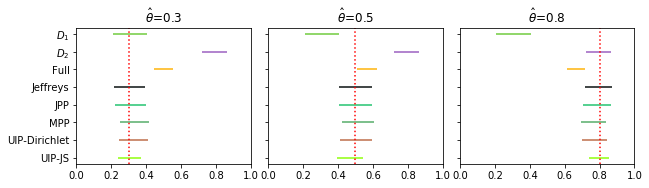

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=False,sharey=True, figsize=(10,2.5))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
cols = list(sns.xkcd_rgb.values())
keys = ["UIP-JS", "UIP-Dirichlet", "MPP", "JPP", r"Jeffreys", "Full", r"$D_2$", r"$D_1$"]
ords = ["UIPJS", "UIPD", "MPP", "JPP", "JEF", "FULL", "D2", "D1"]
for j in range(3):
    resCIs, paras= ressave[j]
    axes[j].set_xlim([0, 1])
    tl = r"$\hat{\theta}$" + f"={paras.p0}"
    axes[j].set_title(tl)
    for idx, key in enumerate(ords):
        axes[j].hlines(idx, xmin=resCIs[key][0], xmax=resCIs[key][1], color=cols[idx])
    axes[j].axvline(paras.p0, linestyle=":", color="red")
    axes[j].set_yticks(list(range(len(keys))))
    axes[j].set_yticklabels(keys)
plt.savefig("BernCIs.pdf")